In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
S0 = 8276.43         
T = 0.0951864535768645   
#T = 0.171898782343988
r = 0            
N = 2000               
M = 10000          

parameter_sets = {
    'A': (1.0, 0.2, 0.6, -0.8, 0.5),
    'B': (1.0, 0.2, 0.6, -0.4, 1.0),
    'C': (5.0, 0.04, 0.6, -0.4, 1.0),
    'D': (1.5, 0.04, 0.04, -0.7, 0.3),
}



In [3]:
def heston_model(S0,v0,rho,upsilon,eta,lmbda,T,N,M):
    #coloumn j is the stock price at time j, row i is stock path i
    S= np.zeros((M,N))
    v = np.zeros((M,N))
    S[:,0]=S0
    v[:,0] = v0
    dt = T/N
    #random variables we will use
    W_1_t = np.random.normal(0,1,(M,N))
    W_2_t = np.random.normal(0,1,(M,N))
    for i in range(1,N):
        v[:,i] = np.maximum(v[:,i-1] + lmbda*(upsilon - v[:,i-1])*dt + eta* np.sqrt(v[:,i-1]*dt) * W_1_t[:,i],0)
        S[:,i] = S[:,i-1]*np.exp(-0.5*v[:,i-1]*dt + np.sqrt(v[:,i-1]*dt)*(rho*W_1_t[:,i] + np.sqrt(1-rho**2)*W_2_t[:,i]))
    return S

In [4]:
#Generates the bid ask price by the method in paper
def generate_bid_ask(prices):
    bid = []
    ask = []
    for i in prices:
        if i > 20:
            bid_initial = i - i%5
            ask_initial = bid_initial + 5
        else:
            bid_initial = i - i%2
            ask_initial = bid_initial + 2
        geom_ask = np.random.geometric(0.8)
        geom_bid = np.random.geometric(0.8)
        for j in range(geom_ask-1):
            if ask_initial >= 20:
                ask_initial += 5
            else:
                ask_initial += 2
        for j in range(geom_bid-1):
            if bid_initial > 20:
                bid_initial -= 5
            elif bid_initial > 0:
                bid_initial -= 2
        bid.append(bid_initial)
        ask.append(ask_initial)
    return bid, ask

In [5]:
#Generates option prices using monte carlo sims
all_simulated_data = {}
strikes = np.arange(7250,17501,250)

# generate simulated data from scratch or load pre generated data
load = True

for label, (kappa, theta, v0, rho, sigma) in parameter_sets.items():
    if not load:
        print(f"Simulating parameter set {label}...")
        call_price = []
        put_price = []


        for K in strikes:
            S = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)
            final_s = S[-1,:]
            call_price.append(np.mean(np.maximum(final_s-K,0)))
            S = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)
            final_s = S[-1,:]
            put_price.append(np.mean(np.maximum(K-final_s,0)))
            
            
        C_bid, C_ask = generate_bid_ask(call_price)
        P_bid, P_ask = generate_bid_ask(put_price)
        simulated_data = pd.DataFrame(data = { "Call_ask": C_ask, "Call_theoretical" : call_price, "Call_bid" : C_bid, "Put_ask": P_ask, "Put_theoretical":put_price,"Put_bid":P_bid}, index = strikes)
    
    else:
        simulated_data = pd.read_pickle("simulated_data_" + label + ".pkl")
    
    all_simulated_data[label] = simulated_data


In [6]:
print(all_simulated_data['A'])
if not load:
    all_simulated_data['A'].to_pickle("simulated_data_A.pkl")

       Call_ask  Call_theoretical  Call_bid  Put_ask  Put_theoretical  Put_bid
7250     1370.0       1369.763398    1365.0    330.0       327.607049    325.0
7500     1210.0       1202.003374    1200.0    420.0       418.944293    415.0
7750     1065.0       1060.650908    1055.0    525.0       515.740973    515.0
8000      895.0        894.242169     890.0    640.0       635.310954    635.0
8250      780.0        775.958962     775.0    750.0       748.390514    745.0
8500      665.0        664.381843     650.0    900.0       896.796798    890.0
8750      605.0        586.418895     585.0   1040.0      1039.742804   1035.0
9000      485.0        484.041026     480.0   1220.0      1216.594878   1210.0
9250      400.0        395.422816     395.0   1365.0      1360.701248   1360.0
9500      340.0        339.748494     335.0   1595.0      1589.572683   1585.0
9750      285.0        281.050902     280.0   1780.0      1775.443359   1775.0
10000     240.0        238.763380     235.0   1960.0

In [7]:
print(all_simulated_data['B'])
if not load:
    all_simulated_data['B'].to_pickle("simulated_data_B.pkl")

       Call_ask  Call_theoretical  Call_bid  Put_ask  Put_theoretical  Put_bid
7250     1365.0       1360.629505    1335.0    330.0       329.887566    320.0
7500     1215.0       1213.174115    1210.0    420.0       414.612364    410.0
7750     1065.0       1060.797449    1060.0    510.0       508.781903    505.0
8000      910.0        901.905975     900.0    640.0       637.556950    635.0
8250      775.0        766.796854     765.0    760.0       754.039746    745.0
8500      655.0        652.128272     645.0    865.0       864.062852    860.0
8750      555.0        550.084726     550.0   1035.0      1031.689373   1030.0
9000      470.0        467.895761     465.0   1220.0      1205.426600   1205.0
9250      400.0        395.040768     395.0   1385.0      1383.793332   1380.0
9500      340.0        337.652102     335.0   1545.0      1539.891512   1535.0
9750      265.0        262.774404     260.0   1770.0      1764.346635   1760.0
10000     225.0        222.618129     220.0   1960.0

In [8]:
print(all_simulated_data['C'])
if not load:
    all_simulated_data['C'].to_pickle("simulated_data_C.pkl")

       Call_ask  Call_theoretical  Call_bid  Put_ask  Put_theoretical  Put_bid
7250     1300.0       1295.452300    1295.0    290.0       289.098457    285.0
7500     1155.0       1152.655379    1150.0    355.0       352.834149    345.0
7750      975.0        970.951854     970.0    460.0       457.625057    445.0
8000      855.0        843.877310     830.0    565.0       564.624370    560.0
8250      715.0        713.921401     710.0    700.0       691.430260    690.0
8500      585.0        584.324947     580.0    830.0       828.444541    825.0
8750      480.0        475.580856     470.0    985.0       980.755829    965.0
9000      425.0        420.817904     420.0   1150.0      1148.707367   1140.0
9250      350.0        348.086722     345.0   1305.0      1299.786401   1295.0
9500      300.0        288.192878     285.0   1495.0      1494.568947   1485.0
9750      230.0        227.058796     220.0   1690.0      1688.326571   1685.0
10000     180.0        178.187267     170.0   1935.0

In [9]:
print(all_simulated_data['D'])
if not load:
    all_simulated_data['D'].to_pickle("simulated_data_D.pkl")

       Call_ask  Call_theoretical  Call_bid  Put_ask  Put_theoretical  Put_bid
7250     1040.0       1027.019115    1025.0      8.0         6.342390      6.0
7500      790.0        787.449679     785.0     20.0        19.217107     16.0
7750      560.0        559.001150     555.0     45.0        44.166737     40.0
8000      390.0        380.805827     380.0    100.0        98.262066     95.0
8250      215.0        212.308561     210.0    195.0       190.389007    185.0
8500      110.0        105.840472     105.0    335.0       331.505828    330.0
8750       45.0         41.676674      40.0    525.0       515.130491    515.0
9000       14.0         11.922790      10.0    735.0       734.607557    730.0
9250        6.0          2.591853       2.0    985.0       982.197256    980.0
9500        2.0          0.616910       0.0   1225.0      1221.381705   1220.0
9750        2.0          0.109197       0.0   1475.0      1473.568671   1470.0
10000       2.0          0.000000       0.0   1720.0

In [10]:
true_qv_dict = {}

for label, (kappa, theta, v0, rho, sigma) in parameter_sets.items():
    true_qv = theta + ((1 - np.exp(-T * kappa)) / (kappa * T)) * (v0 - theta)
    true_qv_dict[label] = true_qv
    print(f"True QV for parameter set {label}: {true_qv}")


True QV for parameter set A: 0.5815526354855551
True QV for parameter set B: 0.5815526354855551
True QV for parameter set C: 0.4855862712811161
True QV for parameter set D: 0.04


In [11]:
def compute_cboe_variance(df, T):
    df = df.copy()
    df = df.sort_values(by='strike') 
    df['call_mid'] = 0.5 * (df['Call_bid'] + df['Call_ask'])
    df['put_mid'] = 0.5 * (df['Put_bid'] + df['Put_ask'])

    # ΔK
    strikes = df['strike'].values
    delta_K = np.zeros_like(strikes)
    delta_K[1:-1] = 0.5 * (strikes[2:] - strikes[:-2])
    delta_K[0] = strikes[1] - strikes[0]
    delta_K[-1] = strikes[-1] - strikes[-2]
    df['delta_K'] = delta_K

    # F: ATM option
    df['call_put_diff'] = np.abs(df['call_mid'] - df['put_mid'])
    K0_index = df['call_put_diff'].idxmin()
    F = df.loc[K0_index, 'strike']
    K0 = F

    # Q(K): OTM option mid price
    df['Q_K'] = np.where(
        df['strike'] < K0, df['put_mid'],
        np.where(df['strike'] > K0, df['call_mid'], 0.5 * (df['put_mid'] + df['call_mid']))
    )

    # CBOE QV 
    term1 = (df['delta_K'] / df['strike'] ** 2 * df['Q_K']).sum()
    term2 = ((F / K0 - 1) ** 2)
    variance = (2 / T) * term1 - (1 / T) * term2
    return variance


In [12]:
strikes = np.arange(7250, 17501, 250) 

cboe_results = {}

for label in ['A', 'B', 'C', 'D']:
    df = all_simulated_data[label].copy()
    df['strike'] = strikes
    cboe_qv = compute_cboe_variance(df, T)
    cboe_results[label] = cboe_qv
    print(f"CBOE estimated QV for Parameter Set {label}: {cboe_qv:.4f}")


CBOE estimated QV for Parameter Set A: 0.4603
CBOE estimated QV for Parameter Set B: 0.4534
CBOE estimated QV for Parameter Set C: 0.3925
CBOE estimated QV for Parameter Set D: 0.0427


# Paper Method of Computing Expected Volatility

In [13]:
# step 1

# determine K_0 which corresponds to the strike price at which difference between put and call options prices is minimised
# Where multiple sets of options have the same difference, the highest strike is selected
# For some reason we use transaction data here rather than mid prices or bid/ask data...

import numpy as np

def get_k(strikes, calls, puts):
    
    
    current_min = np.abs(calls["Trans."][strikes[0]] - puts["Trans."][strikes[0]])
    if calls["Trans."][strikes[0]] == 0 or puts["Trans."][strikes[0]] == 0: # if either price is 0 we ignore them
        current_min = np.inf 
    current_strike = strikes[0]
    for strike in strikes:
        if calls["Trans."][strike] != 0 and  puts["Trans."][strike] != 0:
            difference = np.abs(calls["Trans."][strike] - puts["Trans."][strike])
        
            if difference < current_min:
                current_min = difference
                current_strike = strike
    
    return current_strike


# rate in the paper is the 3-months certificates of deposit rates as a proxy
def get_forward(K, r, T, calls, puts):
    return K + np.exp(r * T)*(calls["Trans."][K] - puts["Trans."][K]) # again probably use the mid price

def bid_ask_available(option, strike):
    if option["Ask"][strike] == 0 and option["Bid"][strike] == 0:
        return False

    else:
        return True

reliable_ratio = 2 # Have a magic number, to make sure bids and asks are sufficiently close to be reliable

# function to check if options are reliable
def reliable_option(option, strike, reliable_ratio):
    if option["Bid"][strike] == 0:
        return False
    elif option["Ask"][strike]/option["Bid"][strike] >= reliable_ratio:
        return False
    return True


# Function to get viable puts
def get_viable_puts(K_0, put, strikes):
    viable_put_strikes = []
    for strike in strikes:
        if strike <= K_0:
            if bid_ask_available(put,strike) and reliable_option(put, strike, reliable_ratio):
                viable_put_strikes.append(strike)
    return viable_put_strikes

# Function to get viable calls
def get_viable_calls(K_0, call, strikes):
    viable_call_strikes = []
    for strike in strikes:
        if strike > K_0:
            if bid_ask_available(call,strike) and reliable_option(call, strike, reliable_ratio):
                    viable_call_strikes.append(strike)
    return viable_call_strikes

# Then for each option compute d_2 and sigma based on the option price by inverting Black Scholes through Bisection

desired_error = 10**(-9)


from scipy.stats import norm

# Black scholes formula, to allow for inversion
def black_scholes_put(r, K, sigma, F, T):
    k = np.log(K/F)
    d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
    d_1 = d_2 + sigma * np.sqrt(T)
    
    return np.exp(-r*T)*(norm.cdf(-d_2) * K - norm.cdf(-d_1) * F)

def black_scholes_call(r, K, sigma, F, T):
    k = np.log(K/F)
    d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
    d_1 = d_2 + sigma * np.sqrt(T)
    
    return np.exp(-r*T)*(norm.cdf(d_1) * F - norm.cdf(d_2) * K)


from scipy.optimize import bisect

def call_implied_vol(call_price, K, r, F, T):
    def call_wrapper(sigma):
        return black_scholes_call(r, K, sigma, F, T) - call_price
    return (bisect(call_wrapper, 0, 100, xtol = desired_error)) ** 2 # Have to square since we're actually root finding for sigma rather than the vol

def put_implied_vol(put_price, K, r, F, T):
    def put_wrapper(sigma):
        return black_scholes_put(r, K, sigma, F, T) - put_price
    return (bisect(put_wrapper, 0, 100, xtol = desired_error)) ** 2 # Have to square since we're actually root finding for sigma rather than the vol

def get_d_2(sigma, T, F, K):
    return (np.log(F/K) - 0.5 * sigma * sigma * T) / sigma / np.sqrt(T)




# function to ensure we have monotonicity in d_2 by removing any strikes after monotonicity fails from the smallest put strike to the largest call strike retained
def ensure_monotonicity_in_d_2(options_data, put_strikes, call_strikes):
    # remove all puts that aren't monotonic
    current_d_2 = options_data["d_2"][put_strikes[-1]]

    fail = False
    for put_strike in reversed(put_strikes):
        new_d_2 = options_data["d_2"][put_strike]

        if new_d_2 < current_d_2 or fail:
            options_data = options_data.drop(put_strike)
            fail = True
        else:
            current_d_2 = new_d_2


    # remove all calls that aren't monotonic
    current_d_2 = options_data["d_2"][call_strikes[0]]
    
    fail = False
    for call_strike in call_strikes:
        new_d_2 = options_data["d_2"][call_strike]

        if new_d_2 > current_d_2 or fail:
            options_data = options_data.drop(call_strike)
            fail = True
        else:
            current_d_2 = new_d_2

    return options_data

def get_curated_options_data(r, F, T, viable_calls, viable_puts):
    viable_strikes = []
    strike_type = []
    prices = []
    d_2s = []
    vols = []

    # Just adding in necessary data points
    for strike in viable_puts:
        viable_strikes.append(strike)
        strike_type.append("P")
        prices.append(puts["Midprice"][strike])
        vols.append(put_implied_vol(puts["Midprice"][strike], strike, r, F, T))
        d_2s.append(get_d_2(np.sqrt(vols[-1]), T, F, strike))

    for strike in viable_calls:
        viable_strikes.append(strike)
        strike_type.append("C")
        prices.append(calls["Midprice"][strike])
        vols.append(call_implied_vol(calls["Midprice"][strike], strike, r, F, T))
        d_2s.append(get_d_2(np.sqrt(vols[-1]), T, F, strike))

    curated_options_data = pd.DataFrame({"Strikes" : viable_strikes, "Type" : strike_type, "Price" : prices, "d_2" : d_2s, "Vol" : vols})
    curated_options_data = curated_options_data.set_index("Strikes")


    # Finally need to ensure monotonicity
    curated_options_data = ensure_monotonicity_in_d_2(curated_options_data, viable_puts, viable_calls)

    return curated_options_data
    
# A function to add polynomial coefficients to the options data
def add_polynomial_coefficients(curated_options_data):
    curated_options_data['b'] = 0.
    curated_options_data['c'] = 0.
    curated_options_data['d'] = 0.

    viable_strikes = curated_options_data.index # Have to recompute as it could have potentially been truncated

    # First compute the y_dashes, which is the same as b
    # This code is not very efficient... but it doesn't really have to be here, so it just written for readability and ease of bugfixing etc
    for j in range(len(viable_strikes) - 1):
        if j != 0 and j != len(viable_strikes) - 1: 
            x_j_minus_one = curated_options_data["d_2"][viable_strikes[j + 1]] # They go in opposite order to the table for some reason which is a bit annoying...
            x_j = curated_options_data["d_2"][viable_strikes[j]]
            x_j_plus_one = curated_options_data["d_2"][viable_strikes[j - 1]]

            y_j_minus_one = curated_options_data["Vol"][viable_strikes[j + 1]]
            y_j = curated_options_data["Vol"][viable_strikes[j]]
            y_j_plus_one = curated_options_data["Vol"][viable_strikes[j - 1]]

            l_j = np.sqrt((x_j - x_j_minus_one)**2 + (y_j - y_j_minus_one)**2)
            l_j_plus_one = np.sqrt((x_j_plus_one - x_j)**2 + (y_j_plus_one - y_j)**2)

            curated_options_data.loc[viable_strikes[j], "b"] = -((x_j_plus_one - x_j)/l_j_plus_one - (x_j - x_j_minus_one)/l_j)/((y_j_plus_one - y_j)/l_j_plus_one - (y_j - y_j_minus_one)/l_j)


    for j in range(len(viable_strikes) - 1):
        if j != 0: 
            x_j_minus_one = curated_options_data["d_2"][viable_strikes[j + 1]] # We're going backwards hence the odd naming...
            x_j = curated_options_data["d_2"][viable_strikes[j]]
            x_j_plus_one = curated_options_data["d_2"][viable_strikes[j - 1]]

            y_j_minus_one = curated_options_data["Vol"][viable_strikes[j + 1]]
            y_j = curated_options_data["Vol"][viable_strikes[j]]
            y_j_plus_one = curated_options_data["Vol"][viable_strikes[j - 1]]

            l_j = np.sqrt((x_j - x_j_minus_one)**2 + (y_j - y_j_minus_one)**2)
            l_j_plus_one = np.sqrt((x_j_plus_one - x_j)**2 + (y_j_plus_one - y_j)**2)

            delta_x_j = x_j_plus_one - x_j
            
            delta_y_j = y_j_plus_one - y_j


            curated_options_data.loc[viable_strikes[j], "c"] = (3 * delta_y_j - delta_x_j * curated_options_data.loc[viable_strikes[j-1], "b"] - 2 * delta_x_j * curated_options_data.loc[viable_strikes[j], "b"])/(delta_x_j * delta_x_j) 
            curated_options_data.loc[viable_strikes[j], "d"] = (delta_y_j - curated_options_data.loc[viable_strikes[j], "b"] * delta_x_j - curated_options_data.loc[viable_strikes[j], "c"] * delta_x_j * delta_x_j)/(delta_x_j * delta_x_j * delta_x_j)


    # Add on first value (since it doesn't use b_j)

    x_j = curated_options_data["d_2"][viable_strikes[(len(viable_strikes) - 1)]]
    x_j_plus_one = curated_options_data["d_2"][viable_strikes[(len(viable_strikes) - 1) - 1]]
    y_j = curated_options_data["Vol"][viable_strikes[(len(viable_strikes) - 1)]]
    y_j_plus_one = curated_options_data["Vol"][viable_strikes[(len(viable_strikes) - 1) - 1]]
    delta_x_j = x_j_plus_one - x_j
    delta_y_j = y_j_plus_one - y_j
    curated_options_data.loc[viable_strikes[(len(viable_strikes) - 1)], "c"] = (3 * delta_y_j - delta_x_j * curated_options_data.loc[viable_strikes[(len(viable_strikes) - 1)-1], "b"] - 2 * delta_x_j * curated_options_data.loc[viable_strikes[(len(viable_strikes) - 1)], "b"])/(delta_x_j * delta_x_j) 
    curated_options_data.loc[viable_strikes[(len(viable_strikes) - 1)], "d"] = (delta_y_j - curated_options_data.loc[viable_strikes[(len(viable_strikes) - 1)], "b"] * delta_x_j - curated_options_data.loc[viable_strikes[(len(viable_strikes) - 1)], "c"] * delta_x_j * delta_x_j)/(delta_x_j * delta_x_j * delta_x_j)

    return curated_options_data

# Function to compute individual polynomial values
def y_function(x, a, b, c, d, x_j):
    return a + b * (x - x_j) + c * (x - x_j)**2 + d * (x - x_j)**3

# Function to return polynomial value at any point for plotting etc
def interpolated_function(x, curated_options_data):
    final_strike = curated_options_data.index[-1]
    first_strike = curated_options_data.index[0]

    if x < curated_options_data["d_2"][final_strike]:
        return curated_options_data["Vol"][final_strike]
    
    if x > curated_options_data["d_2"][first_strike]:
        return curated_options_data["Vol"][first_strike]

    for strike in curated_options_data.index:
        if curated_options_data["d_2"][strike] < x:
            a = curated_options_data["Vol"][strike]
            b = curated_options_data["b"][strike]
            c = curated_options_data["c"][strike]
            d = curated_options_data["d"][strike]

            return y_function(x, a, b, c, d, curated_options_data["d_2"][strike])

# # Integrate each polynomial part explicitly using integration by parts
def polynomial_part_integral(x_1, x_0, a, b, c, d):
    A = norm.cdf(x_1) - norm.cdf(x_0)
    B = norm.pdf(x_0) - norm.pdf(x_1) - A * x_0
    C = (1+x_0*x_0) * A - 2 * x_0 * (norm.pdf(x_0) - norm.pdf(x_1)) + x_0 * norm.pdf(x_0) - x_1 * norm.pdf(x_1)
    D = (x_0 * x_0 + 2) * norm.pdf(x_0) + (3*x_0*x_1 - 3*x_0*x_0 - x_1*x_1 - 2) * norm.pdf(x_1) - x_0 * (3+ x_0 * x_0) * A

    return a * A + b * B + c * C + d * D

# Function to integrate the polynomial given all the data
def integral_volatility_expectation(curated_options_data):
    """Uses constant extrapolation"""
    sum = 0

    strikes = curated_options_data.index
    M = len(strikes)
    for i in range(1, M):
        x_1 = curated_options_data["d_2"][strikes[i-1]] # The order is reversed in the table still... which is why we're going backwards
        x_0 = curated_options_data["d_2"][strikes[i]] 
        a = curated_options_data["Vol"][strikes[i]] 
        b = curated_options_data["b"][strikes[i]] 
        c = curated_options_data["c"][strikes[i]]
        d = curated_options_data["d"][strikes[i]]

        sum += polynomial_part_integral(x_1, x_0, a, b, c, d)

    # Have to deal with the ends slightly differently

    # bottom of polynomial
    x_0 = curated_options_data["d_2"][strikes[M-1]]
    y_0 = curated_options_data["Vol"][strikes[M-1]]

    sum += norm.cdf(x_0) * y_0

    # top of polynomial
    x_0 = curated_options_data["d_2"][strikes[0]]
    y_0 = curated_options_data["Vol"][strikes[0]]

    sum += (1 - norm.cdf(x_0)) * y_0
    
    return sum

# Function to output paper implementation of volatility
def paper_forecast_vol(calls, puts, r, T, debug = False, polynomial_plot = False):

    K_0 = get_k(strikes, calls, puts)

    if debug:
        print("K_0:" + str(K_0))

    F = get_forward(K_0, r, T, calls, puts)
    if debug:
        print("F:" + str(F))

    viable_puts = get_viable_puts(K_0, puts, strikes)
    if debug:
        print("Viable puts:")
        print(viable_puts)


    viable_calls = get_viable_calls(K_0, calls, strikes)
    if debug:
        print("Viable calls:")
        print(viable_calls)


    curated_options_data = get_curated_options_data(r, F, T, viable_calls, viable_puts)
    if debug:
        print("Curated Options Data:")
        print(curated_options_data)

    curated_options_data = add_polynomial_coefficients(curated_options_data)
    if debug:
        print("Curated Options Data with polynomial coefficents:")
        print(curated_options_data)

    if polynomial_plot:
        # Plotting interpolated polynomial

        
        x_s = np.linspace(curated_options_data["d_2"][curated_options_data.index[0]] + 0.3, curated_options_data["d_2"][curated_options_data.index[-1]] - 0.3, 200)

        y_s = np.zeros(len(x_s))

        i = 0
        for x in x_s:
            y_s[i] = interpolated_function(x, curated_options_data)
            i += 1
        plt.plot(x_s, y_s)
        plt.scatter(curated_options_data["d_2"], curated_options_data["Vol"], alpha = 0.5)
        plt.show()


    return integral_volatility_expectation(curated_options_data)


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


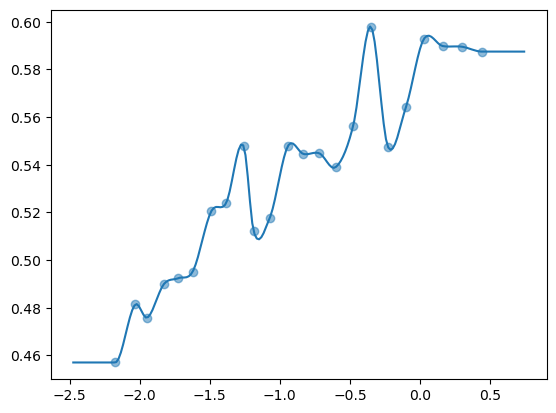

Paper estimated QV for Parameter Set A: 0.5653


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


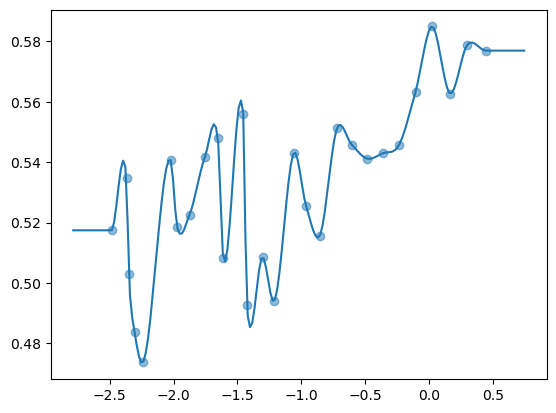

Paper estimated QV for Parameter Set B: 0.5569


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


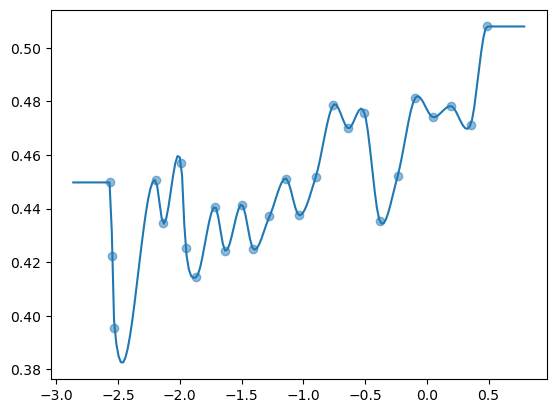

Paper estimated QV for Parameter Set C: 0.4758


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


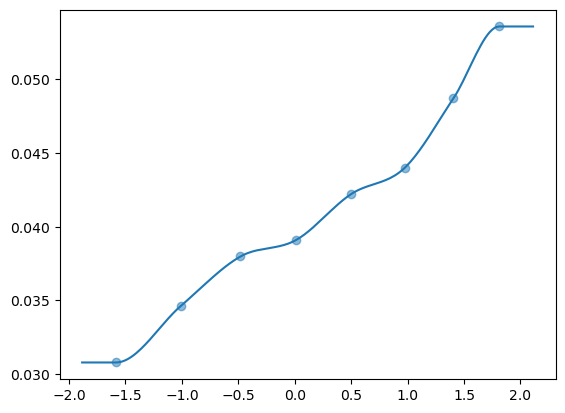

Paper estimated QV for Parameter Set D: 0.0399
dict_values([0.5652691058847981, 0.5568912925980567, 0.4757752095186809, 0.03994318473905168])


In [14]:

strikes = np.arange(7250, 17501, 250) 

paper_results = {}

for label in ['A', 'B', 'C', 'D']:
    df = all_simulated_data[label].copy()
    
    calls = pd.DataFrame({"Strike" : df.index, "Bid" : df["Call_bid"], "Ask" : df["Call_ask"]})
    calls.set_index("Strike")
    calls["Midprice"] = (calls["Bid"] + calls["Ask"])/2
    calls["Trans."] = calls["Midprice"]

    puts = pd.DataFrame({"Strike" : df.index, "Bid" : df["Put_bid"], "Ask" : df["Put_ask"]})
    puts.set_index("Strike")
    puts["Midprice"] = (puts["Bid"] + puts["Ask"])/2
    puts["Trans."] = puts["Midprice"]

    paper_qv = paper_forecast_vol(calls, puts, r, T, polynomial_plot=True)
    paper_results[label] = paper_qv
    print(f"Paper estimated QV for Parameter Set {label}: {paper_qv:.4f}")

print(paper_results.values())

# Natural QV

In [15]:
from scipy.interpolate import CubicSpline
def add_tian_polynomial_coefficients(curated_options_data):
    x = np.array([i for i in reversed(curated_options_data["d_2"].values)])
    y = np.array([i for i in reversed(curated_options_data["Vol"].values)])

    # Get the coefficient from splines (have to reverse everything so x is increasing, then reverse back to get into original format...)
    cs = CubicSpline(x, y, bc_type = 'natural')
    b = np.array([i for i in reversed(np.append(cs.c[2, :],0))])
    c = np.array([i for i in reversed(np.append(cs.c[1, :],0))])
    d = np.array([i for i in reversed(np.append(cs.c[0, :],0))])
    
    
    curated_options_data["b"] = b
    curated_options_data["c"] = c
    curated_options_data["d"] = d

    return curated_options_data

# Function to integrate the polynomial given all the data using linear extrapolation
def tian_integral_volatility_expectation(curated_options_data):
    """Uses linear extrapolation"""
    sum = 0

    strikes = curated_options_data.index
    M = len(strikes)
    for i in range(1, M):
        x_1 = curated_options_data["d_2"][strikes[i-1]] # The order is reversed in the table still... which is why we're going backwards
        x_0 = curated_options_data["d_2"][strikes[i]] 
        a = curated_options_data["Vol"][strikes[i]] 
        b = curated_options_data["b"][strikes[i]] 
        c = curated_options_data["c"][strikes[i]]
        d = curated_options_data["d"][strikes[i]]

        sum += polynomial_part_integral(x_1, x_0, a, b, c, d)

    # Have to deal with the ends slightly differently again
    # In Tian these are linear extrapolations matching the gradient of the previous spline
    # Hence we need the gradient at the interior of each of the end points

    # bottom of polynomial
    x_0 = curated_options_data["d_2"][strikes[M-1]]
    y_0 = curated_options_data["Vol"][strikes[M-1]]
    y_dash_0 = curated_options_data["b"][strikes[M-1]]

    sum += norm.cdf(x_0) * (y_0 - x_0) * y_dash_0 - norm.pdf(x_0) * y_dash_0

    # top of polynomial
    x_0 = curated_options_data["d_2"][strikes[0]]
    y_0 = curated_options_data["Vol"][strikes[0]]
    delta_x = x_0 - curated_options_data["d_2"][strikes[1]]
    y_dash_0 = curated_options_data["b"][strikes[1]] + 2 * curated_options_data["c"][strikes[1]] * delta_x + 3 * curated_options_data["d"][strikes[1]] * delta_x * delta_x
    

    sum += (1 - norm.cdf(x_0)) * (y_0 - y_dash_0 * x_0) + norm.pdf(x_0) * y_dash_0
    
    return sum

# Function to output paper implementation of volatility
def tian_paper_forecast_vol(calls, puts, r, T, debug = False, polynomial_plot = False):

    K_0 = get_k(strikes, calls, puts)

    if debug:
        print("K_0:" + str(K_0))

    F = get_forward(K_0, r, T, calls, puts)
    if debug:
        print("F:" + str(F))

    viable_puts = get_viable_puts(K_0, puts, strikes)
    if debug:
        print("Viable puts:")
        print(viable_puts)


    viable_calls = get_viable_calls(K_0, calls, strikes)
    if debug:
        print("Viable calls:")
        print(viable_calls)


    curated_options_data = get_curated_options_data(r, F, T, viable_calls, viable_puts)
    if debug:
        print("Curated Options Data:")
        print(curated_options_data)

    curated_options_data = add_tian_polynomial_coefficients(curated_options_data)
    if debug:
        print("Curated Options Data with polynomial coefficents:")
        print(curated_options_data)

    if polynomial_plot:
        # Plotting interpolated polynomial

        
        x_s = np.linspace(curated_options_data["d_2"][curated_options_data.index[0]] + 0.3, curated_options_data["d_2"][curated_options_data.index[-1]] - 0.3, 200)

        y_s = np.zeros(len(x_s))

        i = 0
        for x in x_s:
            y_s[i] = interpolated_function(x, curated_options_data)
            i += 1
        plt.plot(x_s, y_s)
        plt.scatter(curated_options_data["d_2"], curated_options_data["Vol"], alpha = 0.5)
        plt.show()


    return tian_integral_volatility_expectation(curated_options_data)

C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


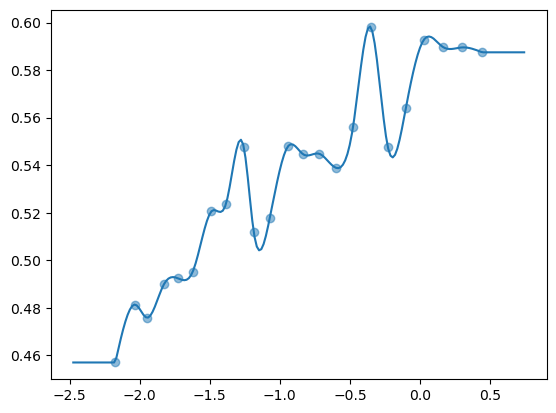

Natural QV for Parameter Set A: 0.5539


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


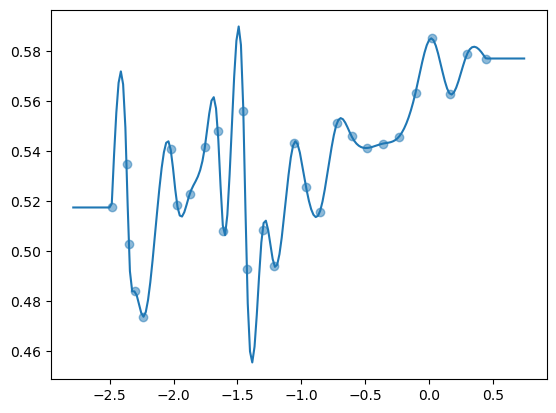

Natural QV for Parameter Set B: 0.5385


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


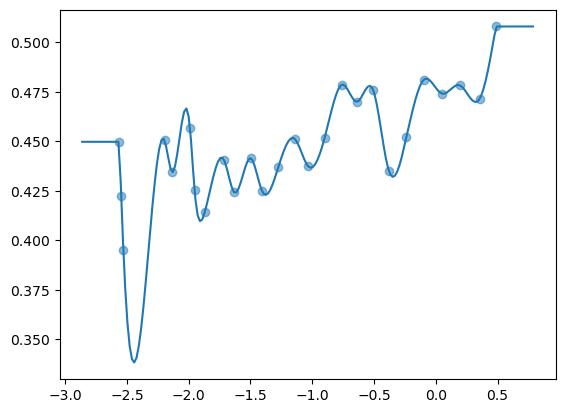

Natural QV for Parameter Set C: 0.5448


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


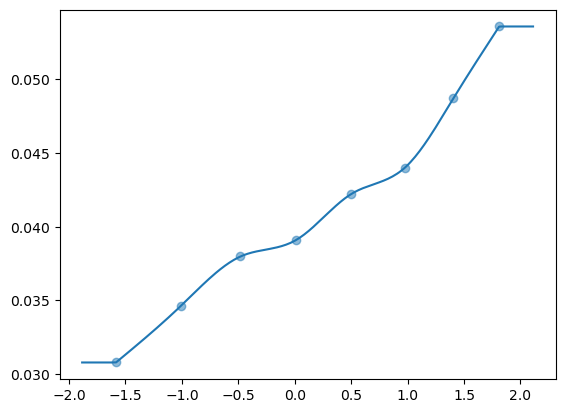

Natural QV for Parameter Set D: 0.0382


In [16]:
strikes = np.arange(7250, 17501, 250) 

tian_paper_results = {}

for label in ['A', 'B', 'C', 'D']:
    df = all_simulated_data[label].copy()
    
    calls = pd.DataFrame({"Strike" : df.index, "Bid" : df["Call_bid"], "Ask" : df["Call_ask"]})
    calls.set_index("Strike")
    calls["Midprice"] = (calls["Bid"] + calls["Ask"])/2
    calls["Trans."] = calls["Midprice"]

    puts = pd.DataFrame({"Strike" : df.index, "Bid" : df["Put_bid"], "Ask" : df["Put_ask"]})
    puts.set_index("Strike")
    puts["Midprice"] = (puts["Bid"] + puts["Ask"])/2
    puts["Trans."] = puts["Midprice"]

    tian_paper_qv = tian_paper_forecast_vol(calls, puts, r, T, polynomial_plot=True)
    tian_paper_results[label] = tian_paper_qv
    print(f"Natural QV for Parameter Set {label}: {tian_paper_qv:.4f}")

# Quad QV

In [17]:
# A function to add polynomial coefficients to the options data
def add_quadratic_polynomial_coefficients(curated_options_data):
    curated_options_data['b'] = 0.
    curated_options_data['c'] = 0.
    curated_options_data['d'] = 0. # leave unused since we have quadratics only

    viable_strikes = curated_options_data.index # Have to recompute as it could have potentially been truncated

    # First compute the y_dashes, which is the same as b
    # This code is not very efficient... but it doesn't really have to be here, so it just written for readability and ease of bugfixing etc
    for j in range(len(viable_strikes)):
        if j != 0: 
             # They go in opposite order to the table for some reason which is a bit annoying...
            x_j = curated_options_data["d_2"][viable_strikes[j]]
            x_j_plus_one = curated_options_data["d_2"][viable_strikes[j - 1]]

            y_j = curated_options_data["Vol"][viable_strikes[j]]
            y_j_plus_one = curated_options_data["Vol"][viable_strikes[j - 1]]

            delta_x_j = x_j_plus_one - x_j
            delta_y_j = y_j_plus_one - y_j

            curated_options_data.loc[viable_strikes[j], "b"] = (2 * delta_y_j - curated_options_data.loc[viable_strikes[j-1], "b"] * delta_x_j) / delta_x_j
            curated_options_data.loc[viable_strikes[j], "c"] = (delta_y_j - curated_options_data.loc[viable_strikes[j], "b"] * delta_x_j) / (delta_x_j * delta_x_j)


    return curated_options_data

# Function to integrate the polynomial given all the data, using constant extrapolation
def own_volatility_expectation(curated_options_data):
    """Currently just uses constant extrapolation"""
    sum = 0

    strikes = curated_options_data.index
    M = len(strikes)
    for i in range(1, M):
        x_1 = curated_options_data["d_2"][strikes[i-1]] # The order is reversed in the table still... which is why we're going backwards
        x_0 = curated_options_data["d_2"][strikes[i]] 
        a = curated_options_data["Vol"][strikes[i]] 
        b = curated_options_data["b"][strikes[i]] 
        c = curated_options_data["c"][strikes[i]]
        d = curated_options_data["d"][strikes[i]]

        sum += polynomial_part_integral(x_1, x_0, a, b, c, d)

    # Have to deal with the ends slightly differently

    # bottom of polynomial
    x_0 = curated_options_data["d_2"][strikes[M-1]]
    y_0 = curated_options_data["Vol"][strikes[M-1]]

    sum += norm.cdf(x_0) * y_0

    # top of polynomial
    x_0 = curated_options_data["d_2"][strikes[0]]
    y_0 = curated_options_data["Vol"][strikes[0]]

    sum += (1 - norm.cdf(x_0)) * y_0
    
    return sum

# Function to output paper implementation of volatility
def quadratic_forecast_vol(calls, puts, r, T, debug = False, polynomial_plot = False):

    K_0 = get_k(strikes, calls, puts)

    if debug:
        print("K_0:" + str(K_0))

    F = get_forward(K_0, r, T, calls, puts)
    if debug:
        print("F:" + str(F))

    viable_puts = get_viable_puts(K_0, puts, strikes)
    if debug:
        print("Viable puts:")
        print(viable_puts)


    viable_calls = get_viable_calls(K_0, calls, strikes)
    if debug:
        print("Viable calls:")
        print(viable_calls)


    curated_options_data = get_curated_options_data(r, F, T, viable_calls, viable_puts)
    if debug:
        print("Curated Options Data:")
        print(curated_options_data)

    curated_options_data = add_quadratic_polynomial_coefficients(curated_options_data)
    if debug:
        print("Curated Options Data with polynomial coefficents:")
        print(curated_options_data)

    if polynomial_plot:
        # Plotting interpolated polynomial

        
        x_s = np.linspace(curated_options_data["d_2"][curated_options_data.index[0]] + 0.3, curated_options_data["d_2"][curated_options_data.index[-1]] - 0.3, 200)

        y_s = np.zeros(len(x_s))

        i = 0
        for x in x_s:
            y_s[i] = interpolated_function(x, curated_options_data)
            i += 1
        plt.plot(x_s, y_s)
        plt.scatter(curated_options_data["d_2"], curated_options_data["Vol"], alpha = 0.5)
        plt.show()


    return integral_volatility_expectation(curated_options_data)

C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


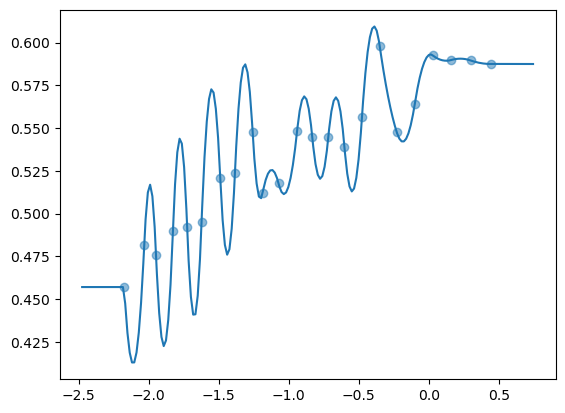

Quad QV for Parameter Set A: 0.5654


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


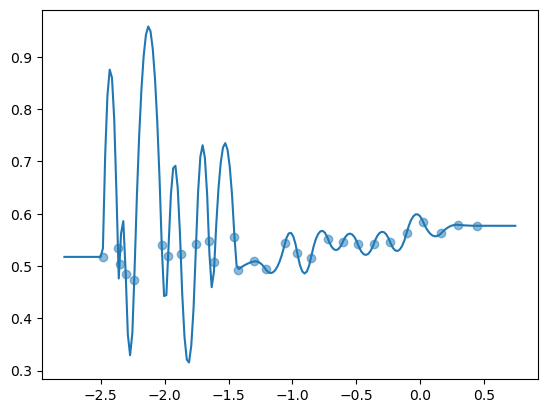

Quad QV for Parameter Set B: 0.5625


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


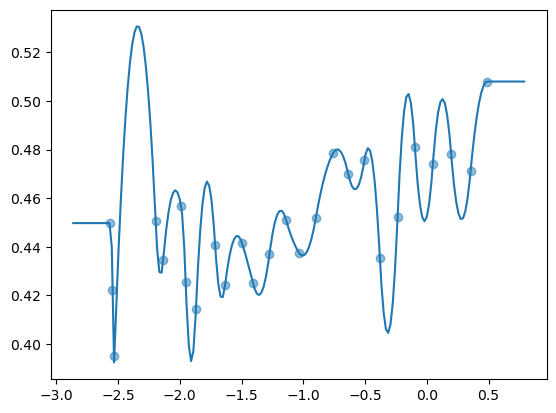

Quad QV for Parameter Set C: 0.4763


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


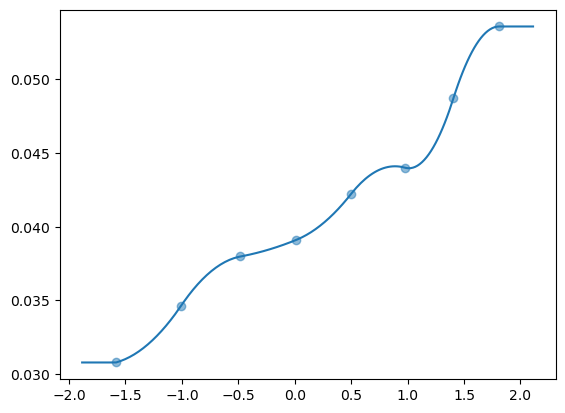

Quad QV for Parameter Set D: 0.0400


In [18]:
strikes = np.arange(7250, 17501, 250) 

our_results = {}

for label in ['A', 'B', 'C', 'D']:
    df = all_simulated_data[label].copy()
    
    calls = pd.DataFrame({"Strike" : df.index, "Bid" : df["Call_bid"], "Ask" : df["Call_ask"]})
    calls.set_index("Strike")
    calls["Midprice"] = (calls["Bid"] + calls["Ask"])/2
    calls["Trans."] = calls["Midprice"]

    puts = pd.DataFrame({"Strike" : df.index, "Bid" : df["Put_bid"], "Ask" : df["Put_ask"]})
    puts.set_index("Strike")
    puts["Midprice"] = (puts["Bid"] + puts["Ask"])/2
    puts["Trans."] = puts["Midprice"]

    our_qv = quadratic_forecast_vol(calls, puts, r, T, polynomial_plot=True)
    our_results[label] = our_qv
    print(f"Quad QV for Parameter Set {label}: {our_qv:.4f}")

# Clamped QV

In [19]:
def add_linear_tian_polynomial_coefficients(curated_options_data):
    x = np.array([i for i in reversed(curated_options_data["d_2"].values)])
    y = np.array([i for i in reversed(curated_options_data["Vol"].values)])

    # Get the coefficient from splines (have to reverse everything so x is increasing, then reverse back to get into original format...)
    cs = CubicSpline(x, y, bc_type = 'clamped') # Clamped ensures the first derivative of the curve is zero at the ends
    b = np.array([i for i in reversed(np.append(cs.c[2, :],0))])
    c = np.array([i for i in reversed(np.append(cs.c[1, :],0))])
    d = np.array([i for i in reversed(np.append(cs.c[0, :],0))])
    
    
    curated_options_data["b"] = b
    curated_options_data["c"] = c
    curated_options_data["d"] = d

    return curated_options_data

# Function to output paper implementation of volatility
def linear_tian_forecast_vol(calls, puts, r, T, debug = False, polynomial_plot = False):

    K_0 = get_k(strikes, calls, puts)

    if debug:
        print("K_0:" + str(K_0))

    F = get_forward(K_0, r, T, calls, puts)
    if debug:
        print("F:" + str(F))

    viable_puts = get_viable_puts(K_0, puts, strikes)
    if debug:
        print("Viable puts:")
        print(viable_puts)


    viable_calls = get_viable_calls(K_0, calls, strikes)
    if debug:
        print("Viable calls:")
        print(viable_calls)


    curated_options_data = get_curated_options_data(r, F, T, viable_calls, viable_puts)
    if debug:
        print("Curated Options Data:")
        print(curated_options_data)

    curated_options_data = add_linear_tian_polynomial_coefficients(curated_options_data)
    if debug:
        print("Curated Options Data with polynomial coefficents:")
        print(curated_options_data)

    if polynomial_plot:
        # Plotting interpolated polynomial

        
        x_s = np.linspace(curated_options_data["d_2"][curated_options_data.index[0]] + 0.3, curated_options_data["d_2"][curated_options_data.index[-1]] - 0.3, 200)

        y_s = np.zeros(len(x_s))

        i = 0
        for x in x_s:
            y_s[i] = interpolated_function(x, curated_options_data)
            i += 1
        plt.plot(x_s, y_s)
        plt.scatter(curated_options_data["d_2"], curated_options_data["Vol"], alpha = 0.5)
        plt.show()


    return integral_volatility_expectation(curated_options_data)

C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


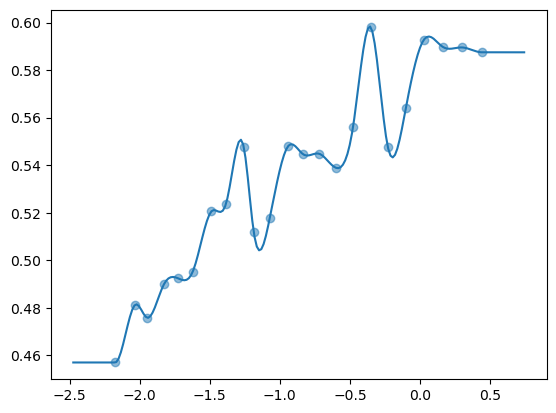

Clamped QV for Parameter Set A: 0.5653


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


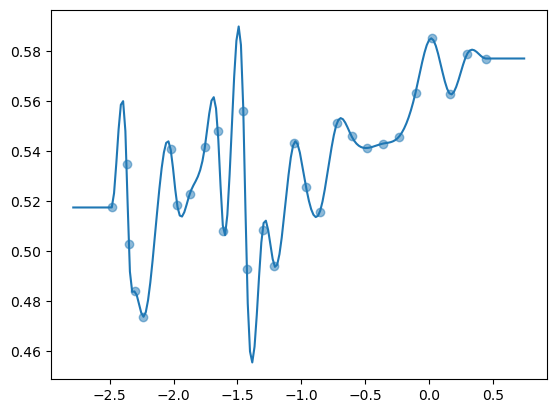

Clamped QV for Parameter Set B: 0.5569


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


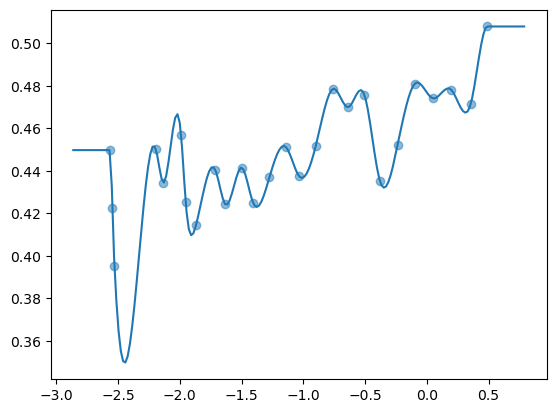

Clamped QV for Parameter Set C: 0.4757


C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2
C:\Users\rapto\AppData\Local\Temp\ipykernel_21540\626294829.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  d_2 = - k / sigma / np.sqrt(T) - sigma * np.sqrt(T) / 2


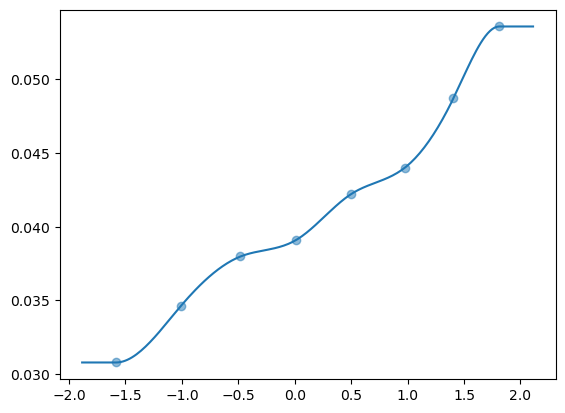

Clamped QV for Parameter Set D: 0.0399


In [20]:
strikes = np.arange(7250, 17501, 250) 

linear_tian_results = {}

for label in ['A', 'B', 'C', 'D']:
    df = all_simulated_data[label].copy()
    
    calls = pd.DataFrame({"Strike" : df.index, "Bid" : df["Call_bid"], "Ask" : df["Call_ask"]})
    calls.set_index("Strike")
    calls["Midprice"] = (calls["Bid"] + calls["Ask"])/2
    calls["Trans."] = calls["Midprice"]

    puts = pd.DataFrame({"Strike" : df.index, "Bid" : df["Put_bid"], "Ask" : df["Put_ask"]})
    puts.set_index("Strike")
    puts["Midprice"] = (puts["Bid"] + puts["Ask"])/2
    puts["Trans."] = puts["Midprice"]

    linear_tian_qv = linear_tian_forecast_vol(calls, puts, r, T, polynomial_plot=True)
    linear_tian_results[label] = linear_tian_qv
    print(f"Clamped QV for Parameter Set {label}: {linear_tian_qv:.4f}")

In [21]:
true_qv = {}
cboe_qv = {}
our_qv = {}

for label, (kappa, theta, v0, rho, sigma) in parameter_sets.items():
    # True QV closed-form
    qv = theta + ((1 - np.exp(-T * kappa)) / (kappa * T)) * (v0 - theta)
    true_qv[label] = qv

    # strike
    df = all_simulated_data[label].copy()
    df['strike'] = strikes

    # CBOE QV
    cboe_qv[label] = compute_cboe_variance(df, T)

# Create a DataFrame
result_df = pd.DataFrame({
    'Parameter': ['A', 'B', 'C', 'D'],
    'True QV': [true_qv[k] for k in ['A', 'B', 'C', 'D']],
    'CBOE QV': [cboe_qv[k] for k in ['A', 'B', 'C', 'D']],
    'Paper QV' : paper_results.values(),
    'Natural QV' : tian_paper_results.values(),
    'Quad QV' : our_results.values(),
    'Clamped QV' : linear_tian_results.values(),
})

result_df = result_df.round(4)

display(result_df)


,Parameter,True QV,CBOE QV,Paper QV,Natural QV,Quad QV,Clamped QV
0,A,0.5816,0.4603,0.5653,0.5539,0.5654,0.5653
1,B,0.5816,0.4534,0.5569,0.5385,0.5625,0.5569
2,C,0.4856,0.3925,0.4758,0.5448,0.4763,0.4757
3,D,0.0400,0.0427,0.0399,0.0382,0.0400,0.0399
